## Import libraries

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from PIL import Image, ImageDraw
from IPython.core.display import HTML

from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials

### Provide valid API credentials

In [2]:
faceEndpoint = ''
faceKey = ''

### Once provided credentials they can be deleted from notebook after running below block.
Below block either dumps credentials to pickle file or load them from it.

In [3]:
if not os.path.isdir("pickles"):
     os.mkdir("pickles")
           
        
if os.path.isfile("pickles/faceKey.pkl"):
    
    with open('pickles/faceEndpoint.pkl', 'rb') as f:
        faceEndpoint = pickle.load(f)
    with open('pickles/faceKey.pkl', 'rb') as f:
        faceKey = pickle.load(f)
    print("Credentials loaded from pickle")
    
else:
    
    if faceKey is None or faceKey == "":
        print("No faceKey provided! Service currently not available")
    else:
        with open('pickles/faceEndpoint.pkl', 'wb') as f:
            pickle.dump(faceEndpoint, f)
        with open('pickles/faceKey.pkl', 'wb') as f:
            pickle.dump(faceKey, f)
            
        print("Credentials written as pickle")

Credentials loaded from pickle


## Authenticate client
Using provided `faceEndpoint` and `faceKey` as in following guide: https://docs.microsoft.com/pl-pl/azure/cognitive-services/face/quickstarts/python-sdk#authenticate-the-client

In [4]:
face_client = FaceClient(faceEndpoint, CognitiveServicesCredentials(faceKey))

# 1. Define needed functions

### Function to <u>only display</u> detected faces on image they come from

In [5]:
def mark_faces(img_, result):
    img = img_.copy()
    # Add rectangles for each face found
    color="blue"
    if result is not None:
        draw = ImageDraw.Draw(img) 
        for currFace in result:
            faceRectangle = currFace.face_rectangle
            left = faceRectangle.left
            top = faceRectangle.top
            width = faceRectangle.width
            height = faceRectangle.height
            draw.line([(left,top),(left+width,top)],fill=color, width=5)
            draw.line([(left+width,top),(left+width,top+height)],fill=color , width=5)
            draw.line([(left+width,top+height),(left, top+height)],fill=color , width=5)
            draw.line([(left,top+height),(left, top)],fill=color , width=5)

    # show the image
    plt.figure(figsize=(6,6))
    plt.imshow(img)

### API function to <u>return</u> detected faces in <u>row format</u>, from an image provided using its <u>url</u>

In [6]:
def detect_faces_url(img_url):
    
    # Detect faces
    result = face_client.face.detect_with_url(img_url)
    
    # Download the image
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    
    # Draw rectangle around found faces
    #mark_faces(img, result)
    
    return {"result" : result, "img" : img}

### API function to <u>return</u> detected faces in <u>row format</u>, from an image <u>stored locally</u>

In [7]:
def detect_faces_local(img_source):
    
    # Read image
    img = Image.open(img_source)
         
    # Detect faces
    result = face_client.face.detect_with_stream(open(img_source, 'r+b'))
    
    # Draw rectangle around found faces
    #mark_faces(img, result)
    
    return {"result" : result, "img" : img}

### Function to crop faces from chosen images
Returns firstly list of face-images in PILLOW format and secondly list of faces ID (ID's are stored on Microsoft Service for 24 hours and are later used to compare faces).

In [8]:
def crop_faces(list_):

    face_image_list = []
    face_id_list = []
    
    for result in list_:
        for face in result['result']:

            face_id_list.append(face.face_id)
            
            rectangle = face.face_rectangle
            left = rectangle.left
            top = rectangle.top
            right = rectangle.left + rectangle.width
            bottom = rectangle.top + rectangle.height

            face_image_list.append(result['img'].crop((left, top, right, bottom)).resize((100,100)))

    # Display cropped faces horizontally 
    fig = plt.figure()#figsize=(1,1))
    for i in range(len(face_image_list)):
        fig.add_subplot(1, len(face_image_list), i+1)
        plt.imshow(face_image_list[i])
        plt.axis('off')
    plt.show()
        
    # Return 2 lists
    return {"image_list" : face_image_list, "id_list" : face_id_list}

### Function to create a correlation matrix between images
A single element tells the `confidence level` for images from corresponding row and column, if they belong to the same person.

**This step is resourse consuming!**

In [9]:
def calculate_matrix(faces):
    
    corr_ = np.zeros((len(faces), len(faces)))

    for i in range(len(faces)):
        for j in range(len(faces)):
            corr_[i][j] = face_client.face.verify_face_to_face(faces[i], faces[j]).confidence
            #sleep(1)"
    return corr_

### Function to return correlation matrix in html format

In [10]:
# Help function to convert from links to html tags
def path_to_image_html(path):
    return '<img src="'+ path + '" width="60" >'


def display_matrix(corr, cropped):
    
    corr2 = pd.DataFrame(corr.copy())
    
    if not os.path.isdir("cropped"):
        os.mkdir("cropped")

    # Save cropped faces locally as images
    links_list = []
    for image, id_ in zip(cropped['image_list'], cropped['id_list']): 
        link = "cropped/{}.jpg".format(id_)
        image.save(link, "JPEG")
        links_list.append(path_to_image_html(link))

    
    # Put images with html tags as indexes and columns
    corr2.index = links_list
    corr2.columns = links_list

    # Display matrix as html-formatted pandas DataFrame
    pd.set_option('display.max_colwidth', -1)
    return HTML(corr2.to_html(escape=False))

# Final function that combines everything

Extract faces from all images in a specified directory and return their correlation matrix in readible format

In [11]:
def process_directory(directory):

    print("Extracting faces...")
    # Proccess every single image in provided folder
    results = []
    for file in os.listdir(directory):
        results.append(detect_faces_local(directory + "/" + file))
    
    # Cropp all detected faces
    cropped = crop_faces(results)
    
    print("Calculating matrix...")
    corr = calculate_matrix(cropped['id_list'])
    
    print("Matrix ready to display!")
    return display_matrix(corr, cropped)

# 2. Process images

Extracting faces...


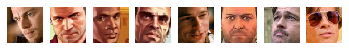

Calculating matrix...
Matrix ready to display!


,,,,,,,,
,1.00000,0.14063,0.08965,0.13866,0.19264,0.21365,0.18313,0.09955
,0.14063,1.00000,0.13801,0.16290,0.10303,0.48605,0.09157,0.09624
,0.08965,0.13801,1.00000,0.25871,0.20915,0.09193,0.09348,0.11766
,0.13866,0.16290,0.25871,1.00000,0.09375,0.10110,0.09031,0.09651
,0.19264,0.10303,0.20915,0.09375,1.00000,0.13309,0.37305,0.32726
,0.21365,0.48605,0.09193,0.10110,0.13309,1.00000,0.15306,0.09724
,0.18313,0.09157,0.09348,0.09031,0.37305,0.15306,1.00000,0.22054
,0.09955,0.09624,0.11766,0.09651,0.32726,0.09724,0.22054,1.00000


In [19]:
matrix_1 = process_directory('images_1')
matrix_1

Extracting faces...


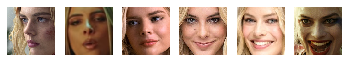

Calculating matrix...
Matrix ready to display!


,,,,,,
,1.00000,0.13569,0.47703,0.16923,0.33544,0.22341
,0.13569,1.00000,0.21783,0.42280,0.11046,0.13615
,0.47703,0.21783,1.00000,0.28296,0.32898,0.28596
,0.16923,0.42280,0.28296,1.00000,0.27686,0.17526
,0.33544,0.11046,0.32898,0.27686,1.00000,0.51990
,0.22341,0.13615,0.28596,0.17526,0.51990,1.00000


In [20]:
matrix_2 = process_directory('images_2')
matrix_2